# Kinetics Analysis with DSC Data

> [Return to examples.md](examples.md)

This notebook demonstrates how to perform a kinetics analysis using Differential Scanning Calorimetry (DSC) data.

## Load Experiment Data
Here we load the data, organize it by heating rate, and prepare it for analysis.

In [1]:
from tadatakit.classes import Experiment
import glob

# Path to DSC kinetics data
data_path = "files/DSC kinetics/*.json"
kinetics_files = glob.glob(data_path)

# Load experiments and organize by heating rate
experiments = {}
for file_path in kinetics_files:
    experiment_name = file_path.rsplit("/", 1)[-1].split(".")[0]
    experiment = Experiment.from_json(file_path)
    heating_rate = float(
        experiment.procedure.steps[1].name.strip("Ramp ").split(" ", 1)[0]
    )
    experiments[heating_rate] = experiment

# Extract dataframes for each experiment
data_frames = {rate: exp.get_dataframe() for rate, exp in sorted(experiments.items())}

## Data Processing Functions

Next, we define functions to locate the peak of the DSC curve, calculate enthalpy, and process data segments.]

In [2]:
import numpy as np


def find_closest_index_and_value(series, target_value):
    """Find the index and closest value in a series to a target."""
    idx = (np.abs(series - target_value)).argmin()
    return idx, series[idx]


def calculate_enthalpy(data, start_idx, end_idx):
    """Calculate the enthalpy by integrating the area under the curve."""
    peak_data = data.iloc[start_idx:end_idx]
    time_seconds = peak_data["Time / min"] * 60
    heat_flow = peak_data["Heat Flow (Normalized) / W/g"]
    baseline = np.interp(
        time_seconds,
        [time_seconds.iloc[0], time_seconds.iloc[-1]],
        [heat_flow.iloc[0], heat_flow.iloc[-1]],
    )
    return np.trapz(heat_flow - baseline, time_seconds)


def process_segments(data, start_temp, end_temp):
    """Process segments of DSC data to calculate thermodynamic properties."""
    min_idx, _ = find_closest_index_and_value(data["Temperature / °C"], start_temp)
    max_idx, _ = find_closest_index_and_value(data["Temperature / °C"], end_temp)
    enthalpy = calculate_enthalpy(data, min_idx, max_idx)

    # Prepare data for visualization and further processing
    segment = data.iloc[min_idx:max_idx]
    temperature = segment["Temperature / °C"]
    time_seconds = segment["Time / min"] * 60
    heat_flow = segment["Heat Flow (Normalized) / W/g"]
    baseline = np.interp(
        temperature,
        [temperature.iloc[0], temperature.iloc[-1]],
        [heat_flow.iloc[0], heat_flow.iloc[-1]],
    )
    normalized_heat_flow = heat_flow - baseline
    time_normalized = (time_seconds - time_seconds.iloc[0]) / 60
    cumulative_heat_flow = normalized_heat_flow.cumsum() / normalized_heat_flow.sum()
    derivative = np.gradient(cumulative_heat_flow, time_normalized)
    peak_temperature = temperature.iloc[np.argmax(derivative)]

    return {
        "Enthalpy / J/g": enthalpy,
        "Temperature / °C": temperature,
        "Heat Flow (Normalized) / W/g": heat_flow,
        "Baseline Heat Flow / W/g": baseline,
        "Peak Temperature / °C": peak_temperature,
    }

## Kinetics Analysis and Visualization

Finally, we will visualize the DSC curves and the region we will use to analyse reaction progress.]

Heating Rate: 1.0°C/min, Enthalpy: 449.27 J/g
Heating Rate: 3.0°C/min, Enthalpy: 429.08 J/g
Heating Rate: 5.0°C/min, Enthalpy: 439.22 J/g
Heating Rate: 10.0°C/min, Enthalpy: 419.18 J/g


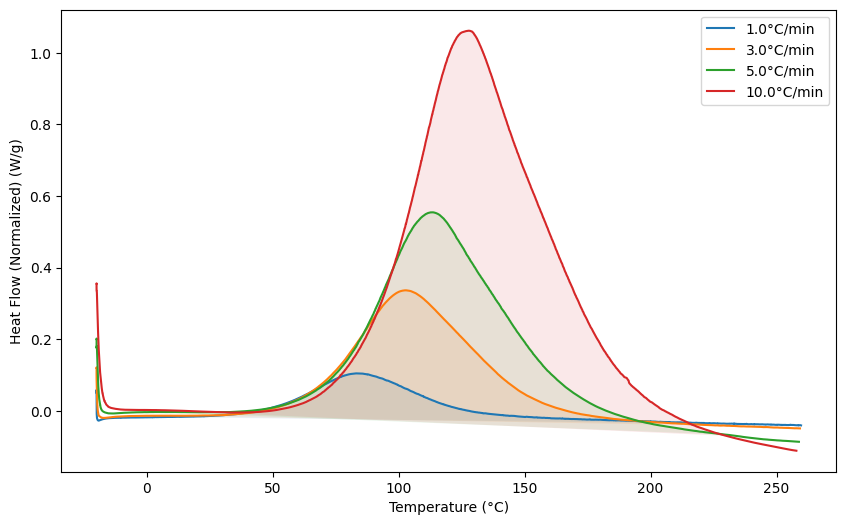

In [3]:
# Process each experiment
results = {rate: process_segments(df, 5, 230) for rate, df in data_frames.items()}

# Process the segments for each heating rate and print enthalpy
for rate, result in results.items():
    print(f"Heating Rate: {rate}°C/min, Enthalpy: {result['Enthalpy / J/g']:.2f} J/g")

# Generate plots to visualize data and enthalpy calculations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for rate, df in data_frames.items():
    plt.plot(
        df["Temperature / °C"],
        df["Heat Flow (Normalized) / W/g"],
        label=f"{rate}°C/min",
    )
    plt.fill_between(
        results[rate]["Temperature / °C"],
        results[rate]["Heat Flow (Normalized) / W/g"],
        results[rate]["Baseline Heat Flow / W/g"],
        alpha=0.1,
    )

plt.xlabel("Temperature (°C)")
plt.ylabel("Heat Flow (Normalized) (W/g)")
plt.legend()
plt.show()

## Activation Energy Calculation

Here we calculate the activation energy from the slope of the Arrhenius plot of Log Heating Rate vs 1/Peak Temperature.

Activation Energy = 60.65 kJ/mol


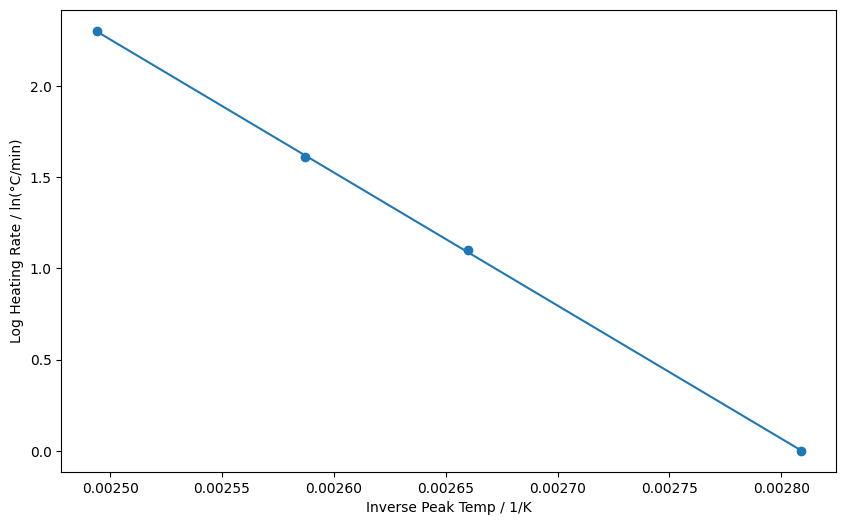

In [4]:
import pandas as pd

# Create a DataFrame from peak temperatures and calculate necessary transformations
results_df = pd.DataFrame.from_dict(results, orient="index").reset_index(
    names=["Heating Rate / °C/min"]
)
results_df["Log Heating Rate / ln(°C/min)"] = np.log(
    results_df["Heating Rate / °C/min"]
)
results_df["Inverse Peak Temp / 1/K"] = 1 / (
    results_df["Peak Temperature / °C"] + 273.15
)

# Perform linear regression
slope, intercept = np.polyfit(
    results_df["Inverse Peak Temp / 1/K"],
    results_df["Log Heating Rate / ln(°C/min)"],
    1,
)
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=results_df["Inverse Peak Temp / 1/K"],
    y=results_df["Log Heating Rate / ln(°C/min)"],
)

# Calculate activation energy
activation_energy = -slope * 8.314
print(f"Activation Energy = {activation_energy/1000:.2f} kJ/mol")

# Plot linear regression
arrhenius_fit_x = np.array(
    [
        results_df["Inverse Peak Temp / 1/K"].min(),
        results_df["Inverse Peak Temp / 1/K"].max(),
    ]
)
arrhenius_fit_y = slope * arrhenius_fit_x + intercept
plt.plot(arrhenius_fit_x, arrhenius_fit_y)
plt.xlabel("Inverse Peak Temp / 1/K")
plt.ylabel("Log Heating Rate / ln(°C/min)")
plt.show()